In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import sympy as sp 
from sympy import *
import random
from scipy.linalg import expm
from sympy.physics.quantum import TensorProduct
import numpy as np 
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
sp.init_printing()

In [2]:
#nomenculture like E01 ground energy of qubit 1 
E11,E01,P1, E_11, E_01, J11 = sp.symbols("E_{11} E_{01} P_{1} E_{11c} E_{01c} J_{11}")
I2 = sp.eye(2)
a_dag = sp.Matrix([[0,0],
                   [1,0]])
sigmap = sp.Matrix([[0,0],[1,0]])
sigmam=sigmap.T
#state of our reservior system 
qr1 = sp.Matrix([[E01,P1.conjugate()],
                 [P1,E11]])
#hamil of res, if more tensor of all
qrh = qr1
c1 = sp.Matrix([[E_01,0],[0,E_11]])
#hamilt of comp sys
ch = c1
#hamil of total system is thus
Hh = TensorProduct(ch,I2) + TensorProduct(I2,qrh)
#can edit values here if need be
E01,E_11c, E_01c = (0,0,0)

ch = ch.subs({"E_{11c}":E_11c, "E_{01c}":E_01c})
qrh = qrh.subs({"E_{11}":E11,"E_{01}":E01,"P_{1}":P1})
#just rewritting hamil with zero potential+gnd state
H = TensorProduct(ch,I2) + TensorProduct(I2,qrh)
#now to introduce coupling 
def MTP(A,B):
    return TensorProduct(A,B)
H = H + J11.conjugate()*(MTP(sigmap,a_dag.T)) + J11 * (MTP(sigmam, a_dag))


In [3]:
#basis vector representation & defining initial computational and reservoir qubits
#assuming QN in vacuum state

gnd_state = np.array([[1],[0]]) #the |0> state

phi_initial_g = np.array([[1],[0]]) #the |0> state for computational qubit
vac = np.array([[1],[0]]) #the |0> state for reservoir qubit
phi_initial_e = np.array([[0],[1]]) #the |1> state for computational qubit

exc_state = np.array([[0],[1]]) #the |1> state

In [5]:
H

⎡       _____                 ⎤
⎢  0    P_{1}     0       0   ⎥
⎢                             ⎥
⎢P_{1}  E_{11}  J_{11}    0   ⎥
⎢                             ⎥
⎢       ______          _____ ⎥
⎢  0    J_{11}    0     P_{1} ⎥
⎢                             ⎥
⎣  0      0     P_{1}   E_{11}⎦

In [41]:
true=6
if true==None:
    print('haha')
elif true==True:
    print('no')
elif true == False: 
    print('ok')
else:
    print('valid condition needed')

valid condition needed


In [73]:
                                        '''
finalstate() applies to three cases: 

1) Single initial state function defined with z1& z2 with
   different P,J,E (user defined) and iterating through evolution of that
   state giving a final state for each P,J,E

2) Sample of intial states(2000 default), keeping P,J,E constant and iterating through the 
   evolution of each state and outputing the final states
   
3) Single initial state with constant z1 & z2 and single P,J,E values and calculating the
   phase change, the relative phase and "more"
   
                                        '''
def finalstate(x1=0.75,y1=0.75,x2=0.25,y2=0.25, 
               Pmax=100, Jmax=5,E=3, Pdiv=5,Jdiv=5, E0=1,t=3,P=40,J=2,
               nsteps=3000, samplesize=2000,multicase =True):
    global var #either state E0 outside function or create global here
    var = E0
    n = samplesize #samplling n initial phi states with coefficients chosen from
    #-E0/2 to +E0/2
    if multicase==True: #Case 1
        P_array = np.linspace(0,Pmax,Pdiv) / var #array P and J values
        lenp = len(P_array)
        J_array = np.linspace(0,Jmax,Jdiv) / var
        lenj=len(J_array)
        hbar = 1
        t = t*var/hbar # defined time
        ham, U= HU(P_array, J_array, t) #Getting corresponding H and U for given P,J,E & t
        #return ham,U
        #z1,z2=z
        z1=complex(x1,y1) # getting the complex coefficients of our intial phi_states 
        z2=complex(x2,y2)
        if x1==0 and y1==0:
            if x1==x2 and y1==y2:
                #print('norm error, random # for complex z2 inserted')
                y2=float(-E0/2 +(np.random.rand(1)*E0)) #-E0/2 to +E0/2
        phi_initial = 1/np.sqrt(np.abs(z1)**2+np.abs(z2)**2) * (
            (z1*phi_initial_g + z2*phi_initial_e) )
        #the |phi_initial>(x)|vac>_QN state = |psi_initial>
        psi_initial = TensorProduct(phi_initial, vac) 
        psi_final = {}
        
        for p in range(lenp):
            for j in range(lenj):
                psi_final[(p,j)] = U[(p,j)]@psi_initial #for each P,J create a corresponding
                # final state where psi_final[(3,4)] corresponds to final state with 
                # P[3] and J[4] value 

        return psi_final, lenp,lenj,P_array, J_array, ham, U,phi_initial, psi_initial,z1,z2,E
    elif multicase == False: #Case 2
        hbar=1
        dt = 0.001 * var/hbar # think like total time your simulation run for
        T = nsteps  * dt #total time
        t = np.arange(0, T+dt, dt)
        Hs, Us = HU(P, J, t=dt, multicase=False)

        phi_initial={} #computational states
        z1array=np.zeros(n, dtype='complex128')
        z2array=np.zeros(n, dtype='complex128')
        for i in range(n):
            x1 = float(-E0/2 +(np.random.rand(1)*E0))
            y1 = float(-E0/2 +(np.random.rand(1)*E0))
            z1 = complex(x1,y1)
            x2 = float(-E0/2 +(np.random.rand(1)*E0))
            y2 = float(-E0/2 +(np.random.rand(1)*E0))
            z2 = complex(x2,y2)
            if z1==0j: # adding a norm condition in which if norm = 1/0 change 
                # one of the complex coeffcients 
                if z1==z2:
                    tmp = z2
                    while tmp==z2:
                        x2 = float(-E0/2 +(np.random.rand(1)*E0))
                        y2 = float(-E0/2 +(np.random.rand(1)*E0))
                        z2 = complex(x2,y2)
            z1array[i]=z1 #collecting the complex coefficients
            z2array[i]=z2
            phi_initial[i] = 1/np.sqrt(np.abs(z1)**2+np.abs(z2)**2)*(
                (z1*phi_initial_g + z2*phi_initial_e) )

        #the |phi_initial> (x)  |vac>_QN state = |psi_initial>    
        psi_initial = {}
        for i in range(n):
            psi_initial[i] =  MTP(phi_initial[i],vac)
            
        psi_out, a, b, c, d=nevolutions(psi_initial,Us,n,t) #this function does the 
        # evolution of each on the n samplled states and stores the complex coeffcients
        # a, b ,c & d array        
        return psi_initial,t,T,Hs,Us,z1array, z2array, a, b, c, d,phi_initial,P,J,E,n,psi_out
    elif multicase == None: #Case 3
        hbar=1
        dt = 0.001 * var/hbar # think like total time your simulation run for
        T = nsteps  * dt #total time
        t = np.arange(0, T+dt, dt)
        Hs, Us = HU(P, J, t=dt, multicase=False)
        
        z1=complex(x1,y1) # getting the complex coefficients of our intial phi_states 
        z2=complex(x2,y2)
        if x1==0 and y1==0:
            if x1==x2 and y1==y2:
                #print('norm error, random # for complex z2 inserted')
                y2=float(-E0/2 +(np.random.rand(1)*E0)) #-E0/2 to +E0/2
        phi_initial = 1/np.sqrt(np.abs(z1)**2+np.abs(z2)**2) * (
            (z1*phi_initial_g + z2*phi_initial_e) )
        
        #the |phi_initial>(x)|vac>_QN state = |psi_initial>
        psi_initial = TensorProduct(phi_initial, vac) 
        
        (a_array,a_complex_real,a_complex_imag,phase_a,
        b_array,b_complex_real,b_complex_imag,phase_b,
        c_array,c_complex_real,c_complex_imag,phase_c,
        d_array,d_complex_real,d_complex_imag,phase_d, t)=nevolutions(psi_initial,Us,n,t, multicase=None)
        return (a_array,a_complex_real,a_complex_imag,phase_a,
                b_array,b_complex_real,b_complex_imag,phase_b,
                c_array,c_complex_real,c_complex_imag,phase_c,
                d_array,d_complex_real,d_complex_imag,phase_d, t)

                                        '''
HU() applies to two cases: 

1) Calculate hamiltonian and corresponding evolution operator for given array of P,J and E
with some time

2) If only a single P,J,E, return a single U and H operator with time increments of dt
for each U evolution

                                        '''
def HU(P_array, J_array, t=3, multicase=True):
    Hcopy=H
    if multicase==True:
        ham={} #for H[(2,3)] corresponds to P[2] and J[3] combination of Hamiltonian
        for p in range(len(P_array)):
            for j in range(len(J_array)):
                ham[(p,j)]=np.array(Hcopy.subs({"E_{11}":E,"P_{1}":P_array[p],
                            "J_{11}":J_array[j]})).astype('complex128') * 1/var
        U = {}
        for p in range(len(P_array)):
            for j in range(len(J_array)):
                U[(p,j)] = expm(-1j* ham[(p,j)] * t)
        return ham, U
    else:
        #single p,j case
        Hs = np.zeros((4,4))
        Us = np.zeros((4,4))
        Hs = np.array(Hcopy.subs({"E_{11}":E,"P_{1}":P_array,
                            "J_{11}":J_array})).astype('complex128') * 1/var
        Us = expm(-1j* Hs * t) #t=dt
        return Hs, Us

                                        '''
density() applies to two cases: 

1) takes in single psi_final for each P,J,E and returns the density matrix
and the reduced density matrix of subsystem A i.e the computational site
for each psi_final

2) for single P,J,E return the density matrix for the sample of n final states
and return the reduced matrix for each of those n final states

                                        '''
def density(psi_final, multicase=True):
    if multicase == True: 
        rho = {} #Case 1
        for p in range(lenp):
            for j in range(lenj):
                rho[(p,j)] =MTP(psi_final[(p,j)],psi_final[(p,j)].conjugate().T)

        rho_c = {}
        Id = np.eye(2) 
        for p in range(lenp):
            for j in range(lenj):
                rho_c[(p,j)] = MTP(Id, gnd_state.conjugate().T)@rho[(p,j)]@(
                MTP(Id, gnd_state ) ) + MTP(Id, exc_state.conjugate().T)@(
                rho[(p,j)]@MTP(Id, exc_state) )

        return rho, rho_c
    else:
        rho = {} #Case 2
        for i in range(len(psi_final)):
            rho[i] = MTP(psi_final[i],psi_final[i].conjugate().T)

        rho_c = {}
        Id = np.eye(2) 
        for i in range(len(rho)):
            rho_c[i] = MTP(Id, gnd_state.conjugate().T)@rho[i]@MTP(Id, gnd_state) + ( 
            MTP(Id, exc_state.conjugate().T) )@rho[i]@MTP(Id, exc_state)
        
        return rho, rho_c
                                        '''
ideal() applies to two cases: 

1) calculates the ideal state when an ideal operator is applied to the single 
intial state we have

2) calculates the ideal states for each intial state started with for a given ideal 
operator
                                        '''
def ideal(phi_initial, uq, multicase=True):
    #X_gate = np.array([[0,1],[1,0]])
        if multicase==True:
            phi_ideal = uq @ phi_initial
            return phi_ideal, uq
        else:
            phi_ideal={}
            for i in range(len(phi_initial)):   
                phi_ideal[i] = uq @ phi_initial[i]
            return phi_ideal, uq
                                        '''
fid() applies to two cases: 

1) calculates the fidelity for the output final reduced density matrix for each 
P,J values and stores it into F[p,j] array

2) calculates the fidelity for the series of output final reduced density matrices
and stores it into F[i] array
                                        '''   
def fid(rho_c,uq=np.array([[0,1],[1,0]]),multicase=True):
    #psi_out,lenp,lenj,P_array,J_array,ham,U,phi_initial,psi_initial = finalstate()
    #rho,rho_c = density(psi_out)
    if multicase==True:
        phi_ideal,uq=ideal(phi_initial,uq) #calling the ideal function to get ideal states
        Ftmp = {}
        F = np.zeros((lenp,lenj))
        for p in range(lenp):
            for j in range(lenj):
                Ftmp[(p,j)]=(phi_ideal.conjugate().T@rho_c[(p,j)]@phi_ideal).real
                F[p,j] = Ftmp[(p,j)][0][0]
        return F
    else:
        phi_ideal, uq = ideal(phi_initial, multicase=False)
        Ftemp = {}
        F = np.zeros(len(rho_c))
        for i in range(len(rho_c)):
            Ftemp[i] = (phi_ideal[i].conjugate().T @ rho_c[i] @ phi_ideal[i]).real
            F[i] = Ftemp[i][0][0]
        return F

                                        '''
nevolutions() takes in the n sample of initial states and evolves 
them with U, where U increments with dt with each operation. 
That is for the first intial state, U is operated on with value of dt then 
increments with +dt until t=T, at each step taking the complex coefficients of the
evolved final state. Then the increment starts again for the next intial state starting 
at t=dt to t=T.
                                        '''
def nevolutions(psi_initial,Us, n, t, multicase):
    
    if multicase ==False: 
        a = 0j
        a_array_tmp = np.zeros(len(t),dtype=np.complex128)
        b = 0j
        b_array_tmp = np.zeros(len(t),dtype=np.complex128)
        c = 0j
        c_array_tmp = np.zeros(len(t),dtype=np.complex128)
        d = 0j
        d_array_tmp = np.zeros(len(t),dtype=np.complex128)

        psi_out = {}
        #from the way I defined this, I have to use k as my iteration tool as if I used i for e.g
        #it will reset/override my array with the current run iteration values which is ofcourse
        #incorrect
        for length in range(len(psi_initial)):
            for i in range(len(t)):
                a_array_tmp[i] = psi_initial[length][0][0] 
                b_array_tmp[i] = psi_initial[length][1][0]
                c_array_tmp[i] = psi_initial[length][2][0]
                d_array_tmp[i] = psi_initial[length][3][0]
                psi_initial[length] = Us @ psi_initial[length]
            #getting the average a,b,c,d value after full evolution of intial state
            a = np.mean(a_array_tmp)
            b = np.mean(b_array_tmp)
            c = np.mean(c_array_tmp)
            d = np.mean(d_array_tmp)
            psi_out[length] = np.array([[a],[b],
                                          [c],[d]])
        return psi_out, a, b, c, d
    
    if multicase ==None:
        a_array = np.zeros(len(t))
        b_array = np.zeros(len(t))
        c_array = np.zeros(len(t))
        d_array = np.zeros(len(t))
        a_complex_real = np.zeros(len(t))
        a_complex_imag = np.zeros(len(t))
        b_complex_real = np.zeros(len(t))
        b_complex_imag = np.zeros(len(t))
        c_complex_real = np.zeros(len(t))
        c_complex_imag = np.zeros(len(t))
        d_complex_real = np.zeros(len(t))
        d_complex_imag = np.zeros(len(t))
        phase_a= np.zeros(len(t))
        phase_b= np.zeros(len(t))
        phase_c= np.zeros(len(t))
        phase_d= np.zeros(len(t))
        for i in range(len(t)):
            a_array[i] = np.abs(psi_initial[0][0])**2 #accessing 0th posn of vector 0
            b_array[i] = np.abs(psi_initial[1][0])**2
            c_array[i] = np.abs(psi_initial[2][0])**2
            d_array[i] = np.abs(psi_initial[3][0])**2 #accessing 3th posn of vector 0
            a_complex_real[i], a_complex_imag[i] =  psi_initial[0][0].real, psi_initial[0][0].imag
            b_complex_real[i], b_complex_imag[i] =  psi_initial[1][0].real, psi_initial[1][0].imag
            c_complex_real[i], c_complex_imag[i] =  psi_initial[2][0].real, psi_initial[2][0].imag
            d_complex_real[i], d_complex_imag[i] =  psi_initial[3][0].real, psi_initial[3][0].imag
            psi_initial = Us @ psi_initial
            phase_a[i]=cmath.phase(psi_initial[0][0])
            phase_b[i]=cmath.phase(psi_initial[1][0])
            phase_c[i]=cmath.phase(psi_initial[2][0])
            phase_d[i]=cmath.phase(psi_initial[3][0])#np.arctan(d_complex_imag[k]/d_complex_real[k])

        return (a_array,a_complex_real,a_complex_imag,phase_a,
                b_array,b_complex_real,b_complex_imag,phase_b,
                c_array,c_complex_real,c_complex_imag,phase_c,
                d_array,d_complex_real,d_complex_imag,phase_d, t)

In [111]:
np.random.rand(3)

array([0.00337556, 0.19566943, 0.14234496])

In [71]:
min(F), max(F)

In [85]:
phi_initial[0]

array([[-0.20145579+0.35008494j],
       [ 0.80607325-0.43255291j]])

In [82]:
psi_final[0],psi_initial[0]

(array([[ 8.99457229e-07+1.11136981e-06j],
        [ 9.76844867e-07+1.58163644e-06j],
        [-8.56410549e-07-2.37105059e-06j],
        [ 7.03721237e-07-3.97385626e-06j]]),
 array([[ 0.17370498+0.11029744j],
        [ 0.26155947-0.23024681j],
        [-0.12509172-0.60063333j],
        [-0.64393177+0.21255032j]]))

In [84]:
z1array[0]

(-0.17463072422289339+0.3034690004406052j)

In [83]:
Us@psi_initial[0]

array([[ 0.16434778+0.09978727j],
       [ 0.26388396-0.23755505j],
       [-0.11692055-0.57494074j],
       [-0.66679836+0.21935778j]])

In [65]:
(phi_ideal[3].conjugate().T@rho_c[3]@phi_ideal[3]).real

array([[8.64429089e-11]])

In [68]:
z1,len(z2array)

((0.75+0.75j), 2000)

In [47]:
len(rho_c)

#                          Main Code
# Case 1: Keeping z1,z2 constant and changing P and J values

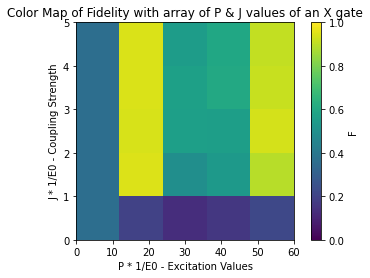


P =  [ 0. 15. 30. 45. 60.] 
J = [0.   1.25 2.5  3.75 5.  ] 
E =  3 
(z1,z2) =
((0.75+0.75j),(0.25+0.25j))


In [85]:
'''
finalstate(x1=0.75,y1=0.75,x2=0.25,y2=0.25, 
               Pmax=100, Jmax=5,E=3, Pdiv=5,Jdiv=5, E0=1,t=3,P=40,J=2,
               nsteps=3000, samplesize=2000,multicase =True)
'''

(psi_final,lenp,lenj,P_array, J_array, ham,
U,phi_initial,psi_initial,z1,z2,E) =finalstate(Pmax=60)

'''
                                density(psi_final, multicase=True)
'''
rho,rho_c=density(psi_final)

'''
                                     fid(rho_c, multicase=True)
'''
F= fid(rho_c)

# fixes an error that comes with plotting meshgrid with my version of matplotlib
# the default auto aspect ratio is modified to fix the meshgrid 
# and not produce an error
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
fig, ax = plt.subplots()
X,Y = np.meshgrid(P_array,J_array)

#creating color map plot with limits of axis in extent
pos=ax.imshow(F, cmap='viridis',extent=[P_array[0],P_array[-1],J_array[-1],J_array[0]], vmin=0,vmax=1)
ax.invert_yaxis()
forceAspect(ax,aspect=1)
ax.set_title('Color Map of Fidelity with array of P & J values of an X gate')
ax.set_xlabel('P * 1/E0 - Excitation Values')
ax.set_ylabel("J * 1/E0 - Coupling Strength")
cbar = plt.colorbar(pos)
cbar.set_label(r'F')
plt.show()
print('\nP = ', P_array, '\nJ =',J_array,'\nE = ',E, f'\n(z1,z2) =\n({z1},{z2})')

In [59]:
F

array([[0.36      , 0.25353428, 0.02277181, 0.23465331, 0.12368889,
        0.21533405],
       [0.36      , 0.99707143, 0.37039352, 0.97183886, 0.41286299,
        0.91117967],
       [0.36      , 0.99723619, 0.36303265, 0.975044  , 0.39134238,
        0.93112725],
       [0.36      , 0.99699142, 0.36148445, 0.97299333, 0.38751812,
        0.92667941],
       [0.36      , 0.9967421 , 0.36337347, 0.97079976, 0.39206365,
        0.92072655]])

testing with different P,J and number of divisions

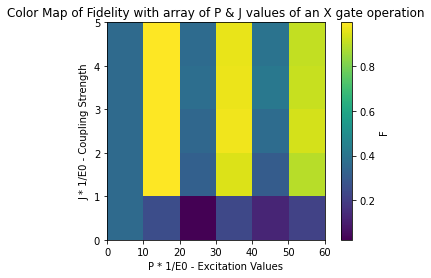


P =  [ 0. 15. 30. 45. 60.] 
J = [0. 1. 2. 3. 4. 5.] 
E =  3 
(z1,z2) =
((0.75+0.75j),(0.25+0.25j))


In [9]:
'''
finalstate(x1=0.75,y1=0.75,x2=0.25,y2=0.25, 
               Pmax=100, Jmax=5,E=3, Pdiv=5,Jdiv=5, E0=1,t=3,P=40,J=2,
               nsteps=3000, samplesize=2000,multicase =True)
'''
(psi_final,lenp,lenj,P_array, J_array, ham,
U,phi_initial,psi_initial,z1,z2,E) =finalstate(Pmax=60,Jdiv=6)


'''
                                density(psi_final, multicase=True)
'''
rho,rho_c=density(psi_final)


F= fid(rho_c)
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
fig, ax = plt.subplots()
X,Y = np.meshgrid(P_array,J_array)
#ax.set_aspect('auto')
#norm_F_array = (F_array - np.min(F_array)) / (np.max(F_array) - np.min(F_array))
pos=ax.imshow(F, cmap='viridis',extent=[P_array[0],P_array[-1],J_array[-1],J_array[0]])
ax.invert_yaxis()
forceAspect(ax,aspect=1)
ax.set_title('Color Map of Fidelity with array of P & J values of an X gate operation')
ax.set_xlabel('P * 1/E0 - Excitation Values')
ax.set_ylabel("J * 1/E0 - Coupling Strength")
cbar = plt.colorbar(pos)
cbar.set_label(r'F')
plt.show()
print('\nP = ', P_array, '\nJ =',J_array,'\nE = ',E, f'\n(z1,z2) =\n({z1},{z2})')

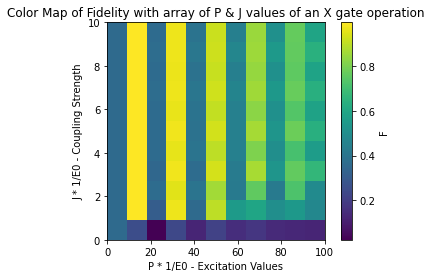


P =  [  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.] 
J = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] 
E =  3 
(z1,z2) =
((0.75+0.75j),(0.25+0.25j))


In [11]:
'''
finalstate(x1=0.75,y1=0.75,x2=0.25,y2=0.25, 
               Pmax=100, Jmax=5,E=3, Pdiv=5,Jdiv=5, E0=1,t=3,P=40,J=2,
               nsteps=3000, samplesize=2000,multicase =True)
'''
(psi_final,lenp,lenj,P_array, J_array, ham,
U,phi_initial,psi_initial,z1,z2,E) =finalstate(Pmax=100,Pdiv=11,Jmax=10,Jdiv=11)


'''
                                density(psi_final, multicase=True)
'''
rho,rho_c=density(psi_final)


F= fid(rho_c)
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
fig, ax = plt.subplots()
X,Y = np.meshgrid(P_array,J_array)
#ax.set_aspect('auto')
#norm_F_array = (F_array - np.min(F_array)) / (np.max(F_array) - np.min(F_array))
pos=ax.imshow(F, cmap='viridis',extent=[P_array[0],P_array[-1],J_array[-1],J_array[0]])
ax.invert_yaxis()
forceAspect(ax,aspect=1)
ax.set_title('Color Map of Fidelity with array of P & J values of an X gate operation')
ax.set_xlabel('P * 1/E0 - Excitation Values')
ax.set_ylabel("J * 1/E0 - Coupling Strength")
cbar = plt.colorbar(pos)
cbar.set_label(r'F')
plt.show()
print('\nP = ', P_array, '\nJ =',J_array,'\nE = ',E, f'\n(z1,z2) =\n({z1},{z2})')

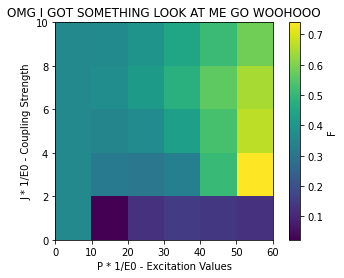


P =  [ 0. 15. 30. 45. 60.] 
J = [ 0.  2.  4.  6.  8. 10.] 
E =  10 
(z1,z2) =
((0.75+0.75j),(0.25+0.25j))


In [120]:
'''
finalstate(x1=0.75,y1=0.75,x2=0.25,y2=0.25, 
               Pmax=100, Jmax=5,E=3, Pdiv=5,Jdiv=5, E0=1,t=3,P=40,J=2,
               nsteps=3000, samplesize=2000,multicase =True)
'''
(psi_final,lenp,lenj,P_array, J_array, ham,
U,phi_initial,psi_initial,z1,z2,E) =finalstate(Pmax=60,E=10,Jmax=10,Jdiv=6)


'''
                                density(psi_final, multicase=True)
'''
rho,rho_c=density(psi_final)


F= fid(rho_c)
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
fig, ax = plt.subplots()
X,Y = np.meshgrid(P_array,J_array)
#ax.set_aspect('auto')
#norm_F_array = (F_array - np.min(F_array)) / (np.max(F_array) - np.min(F_array))
pos=ax.imshow(F, cmap='viridis',extent=[P_array[0],P_array[-1],J_array[-1],J_array[0]])
ax.invert_yaxis()
forceAspect(ax,aspect=1)
ax.set_title('OMG I GOT SOMETHING LOOK AT ME GO WOOHOOO')
ax.set_xlabel('P * 1/E0 - Excitation Values')
ax.set_ylabel("J * 1/E0 - Coupling Strength")
cbar = plt.colorbar(pos)
cbar.set_label(r'F')
plt.show()
print('\nP = ', P_array, '\nJ =',J_array,'\nE = ',E, f'\n(z1,z2) =\n({z1},{z2})')

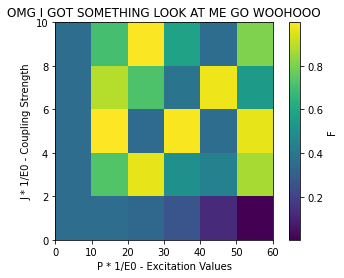


P =  [ 0. 15. 30. 45. 60.] 
J = [ 0.  2.  4.  6.  8. 10.] 
E =  100 
(z1,z2) =
((0.75+0.75j),(0.25+0.25j))


In [128]:
'''
finalstate(x1=0.75,y1=0.75,x2=0.25,y2=0.25, 
               Pmax=100, Jmax=5,E=3, Pdiv=5,Jdiv=5, E0=1,t=3,P=40,J=2,
               nsteps=3000, samplesize=2000,multicase =True)
'''
(psi_final,lenp,lenj,P_array, J_array, ham,
U,phi_initial,psi_initial,z1,z2,E) =finalstate(Pmax=60,E=100,Jmax=10,Jdiv=6)


'''
                                density(psi_final, multicase=True)
'''
rho,rho_c=density(psi_final)


F= fid(rho_c)
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
fig, ax = plt.subplots()
X,Y = np.meshgrid(P_array,J_array)
#ax.set_aspect('auto')
#norm_F_array = (F_array - np.min(F_array)) / (np.max(F_array) - np.min(F_array))
pos=ax.imshow(F, cmap='viridis',extent=[P_array[0],P_array[-1],J_array[-1],J_array[0]])
ax.invert_yaxis()
forceAspect(ax,aspect=1)
ax.set_title('OMG I GOT SOMETHING LOOK AT ME GO WOOHOOO')
ax.set_xlabel('P * 1/E0 - Excitation Values')
ax.set_ylabel("J * 1/E0 - Coupling Strength")
cbar = plt.colorbar(pos)
cbar.set_label(r'F')
plt.show()
print('\nP = ', P_array, '\nJ =',J_array,'\nE = ',E, f'\n(z1,z2) =\n({z1},{z2})')

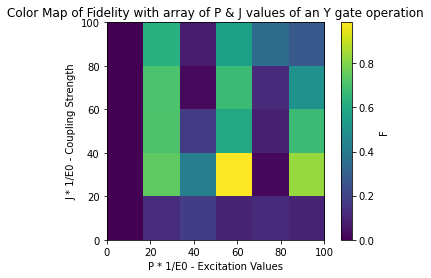


P =  [  0.  25.  50.  75. 100.] 
J = [  0.  20.  40.  60.  80. 100.] 
E =  3 
(z1,z2) =
((0.75+0.75j),(0.25+0.25j))


In [79]:
'''
finalstate(x1=0.75,y1=0.75,x2=0.25,y2=0.25, 
               Pmax=100, Jmax=5,E=3, Pdiv=5,Jdiv=5, E0=1,t=3,P=40,J=2,
               nsteps=3000, samplesize=2000,multicase =True)
'''
(psi_final,lenp,lenj,P_array, J_array, ham,
U,phi_initial,psi_initial,z1,z2,E) =finalstate(Jmax=100,Jdiv=6)


'''
                                density(psi_final, multicase=True)
'''
rho,rho_c=density(psi_final)


F= fid(rho_c, uq=np.array([[0,-1j],[1j,0]]))

np.array([[0,1],[1,0]])
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
fig, ax = plt.subplots()
X,Y = np.meshgrid(P_array,J_array)
#ax.set_aspect('auto')
#norm_F_array = (F_array - np.min(F_array)) / (np.max(F_array) - np.min(F_array))
pos=ax.imshow(F, cmap='viridis',extent=[P_array[0],P_array[-1],J_array[-1],J_array[0]])
ax.invert_yaxis()
forceAspect(ax,aspect=1)
ax.set_title('Color Map of Fidelity with array of P & J values of an Y gate operation')
ax.set_xlabel('P * 1/E0 - Excitation Values')
ax.set_ylabel("J * 1/E0 - Coupling Strength")
cbar = plt.colorbar(pos)
cbar.set_label(r'F')
plt.show()
print('\nP = ', P_array, '\nJ =',J_array,'\nE = ',E, f'\n(z1,z2) =\n({z1},{z2})')

In [347]:
from matplotlib.animation import PillowWriter

In [360]:
E_array = np.array([10,20,30,40,50,60])

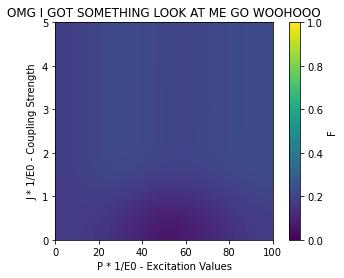


P =  [  0.  25.  50.  75. 100.] 
J = [0.   1.25 2.5  3.75 5.  ] 
E =  10 
(z1,z2) =
((0.30606273844663345+0.2932317059753059j),(0.22270306733627498+0.5466358337590985j))


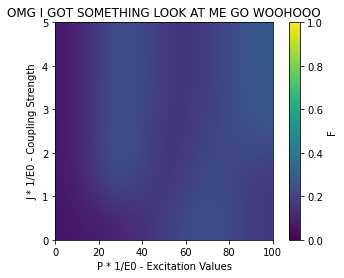


P =  [  0.  25.  50.  75. 100.] 
J = [0.   1.25 2.5  3.75 5.  ] 
E =  20 
(z1,z2) =
((0.07183027875141867-0.3308062858679539j),(-0.39080906388308134-0.3370213842107719j))


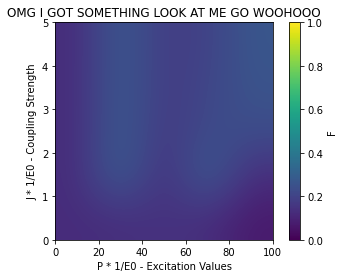


P =  [  0.  25.  50.  75. 100.] 
J = [0.   1.25 2.5  3.75 5.  ] 
E =  30 
(z1,z2) =
((0.7323887256197336+0.2967899728332877j),(0.3260431036428294-0.00435153672514732j))


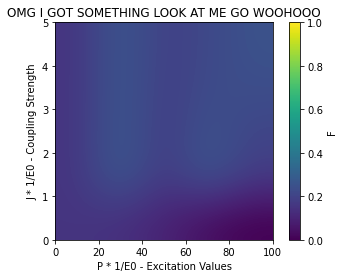


P =  [  0.  25.  50.  75. 100.] 
J = [0.   1.25 2.5  3.75 5.  ] 
E =  40 
(z1,z2) =
((-0.9503517728828207-0.9165801719933764j),(0.14217773341518192+0.8469755870161724j))


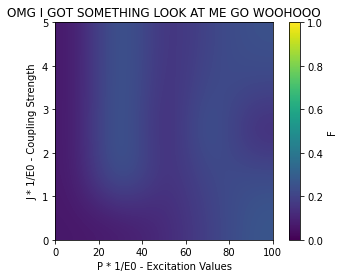


P =  [  0.  25.  50.  75. 100.] 
J = [0.   1.25 2.5  3.75 5.  ] 
E =  50 
(z1,z2) =
((0.3390927274276422-0.7606615080512533j),(0.40465297826424673+0.5017916040461161j))


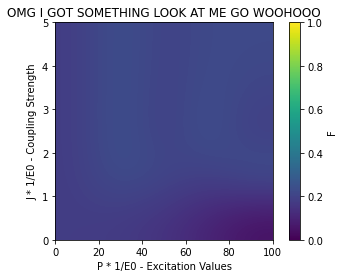


P =  [  0.  25.  50.  75. 100.] 
J = [0.   1.25 2.5  3.75 5.  ] 
E =  60 
(z1,z2) =
((-0.28599053747503567+0.7962661058926244j),(-0.802102595880167+0.7145382046778995j))


In [353]:
metadata=dict(title='movie',artist='me')
writer=PillowWriter(fps=15,metadata=metadata)

with writer.saving(fig, 'kek.gif',100):
    for val in E_array:
        f(E=val)
        writer.grab_frame()
        

In [88]:
psi_out[0]

array([[-9.36060337e-06+3.05750592e-06j],
       [ 3.07148263e-06-1.14404638e-06j],
       [ 9.40570288e-06-3.06541865e-06j],
       [-3.60703623e-06+5.46514979e-07j]])

# CASE 2: KEEPING P,J,E CONSTANT AND SAMPLING 2k STATES

In [89]:
a

(-0.00011959492460211248+3.539214359139986e-05j)

In [27]:
#                                         '''
# nevolutions() takes in the n sample of initial states and evolves 
# them with U, where U increments with dt with each operation. 
# That is for the first intial state, U is operated on with value of dt then 
# increments with +dt until t=T, at each step taking the complex coefficients of the
# evolved final state. Then the increment starts again for the next intial state starting 
# at t=dt to t=T.
#                                         '''
# def nevolutions(psi_initial,Us, n, t):
#     a = 0j
#     a_array_tmp = np.zeros(len(t),dtype=np.complex128)
#     b = 0j
#     b_array_tmp = np.zeros(len(t),dtype=np.complex128)
#     c = 0j
#     c_array_tmp = np.zeros(len(t),dtype=np.complex128)
#     d = 0j
#     d_array_tmp = np.zeros(len(t),dtype=np.complex128)

#     psi_out = {}
#     #from the way I defined this, I have to use k as my iteration tool as if I used i for e.g
#     #it will reset/override my array with the current run iteration values which is ofcourse
#     #incorrect
#     for length in range(len(psi_initial)):
#         for i in range(len(t)):
#             a_array_tmp[i] = psi_initial[length][0][0] 
#             b_array_tmp[i] = psi_initial[length][1][0]
#             c_array_tmp[i] = psi_initial[length][2][0]
#             d_array_tmp[i] = psi_initial[length][3][0]
#             psi_initial[length] = Us @ psi_initial[length]
#         #getting the average a,b,c,d value after full evolution of intial state
#         a = np.mean(a_array_tmp)
#         b = np.mean(b_array_tmp)
#         c = np.mean(c_array_tmp)
#         d = np.mean(d_array_tmp)
#         psi_out[length] = np.array([[a],[b],
#                                       [c],[d]])
#     return psi_out, a, b, c, d


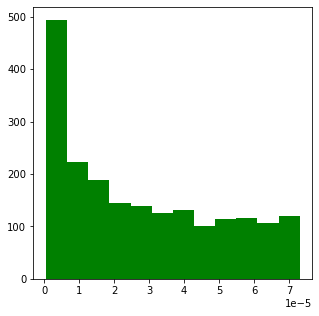

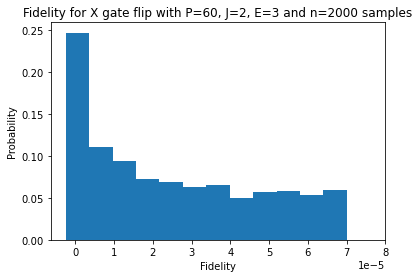

In [33]:
"""
finalstate(x1=0.75,y1=0.75,x2=0.25,y2=0.25, 
               Pmax=100, Jmax=5,E=3, Pdiv=5,Jdiv=5, E0=1,t=3,P=40,J=2,
               nsteps=3000, samplesize=2000,multicase =True) 
"""

(psi_initial,t,T,Hs,Us,z1array, z2array,a, b, c, d,
 phi_initial,P,J,E,n,psi_out)=finalstate(P=60,multicase=False)

"""
density(psi_final, multicase=True)
"""
rho,rho_c=density(psi_out, multicase=False)

"""
fid(rho_c, multicase=True)
"""
F=fid(rho_c,multicase=False)

#makes a histogram from the samples of Fidelity obtained for each intial state
fig=plt.figure(figsize=(5,5))
r,bins,patch=plt.hist(F,bins='auto',density=False,color='g',histtype='bar')
plt.show()
#taking the probability density of the distribution, by taking the number of bins
#and dividing by area taken of the interval distribution 
r=r/len(F)
r=np.append(r,0)
plt.bar(bins,r,width=(bins[len(bins)-1]-bins[0])/(len(bins)-1))
#plt.xlim([0,1])
plt.ylabel('Probability')
plt.xlabel('Fidelity')
plt.title(f'Fidelity for X gate flip with P={P}, J={J}, E={E} and n={n} samples')
plt.show()
#np.histogram(F_norm)        

In [19]:
min(F), max(F)

In [ ]:
"""
finalstate(x1=0.75,y1=0.75,x2=0.25,y2=0.25, 
               Pmax=100, Jmax=5,E=3, Pdiv=5,Jdiv=5, E0=1,t=3,P=40,J=2,
               nsteps=3000, samplesize=2000,multicase =True) 
"""

(psi_initial,t,T,Hs,Us,z1array, z2array,a, b, c, d,
 phi_initial,P,J,E,n,psi_out)=finalstate(P=60,multicase=None)

"""
density(psi_final, multicase=True)
"""
rho,rho_c=density(psi_out, multicase=False)

"""
fid(rho_c, multicase=True)
"""
F=fid(rho_c,multicase=False)

#makes a histogram from the samples of Fidelity obtained for each intial state
fig=plt.figure(figsize=(5,5))
r,bins,patch=plt.hist(F,bins='auto',density=False,color='g',histtype='bar')
plt.show()
#taking the probability density of the distribution, by taking the number of bins
#and dividing by area taken of the interval distribution 
r=r/len(F)
r=np.append(r,0)
plt.bar(bins,r,width=(bins[len(bins)-1]-bins[0])/(len(bins)-1))
#plt.xlim([0,1])
plt.ylabel('Probability')
plt.xlabel('Fidelity')
plt.title(f'Fidelity for X gate flip with P={P}, J={J}, E={E} and n={n} samples')
plt.show()
#np.histogram(F_norm)        

In [32]:
len(psi_out)

In [137]:
F

array([1.90268832e-11, 2.92583588e-11, 4.69141247e-11, ...,
       5.40519347e-08, 2.58832339e-08, 5.63496642e-08])

In [52]:
import cmath

# phase, relative phase

In [54]:
(a_array,a_complex_real,a_complex_imag,phase_a,
b_array,b_complex_real,b_complex_imag,phase_b,
c_array,c_complex_real,c_complex_imag,phase_c,
d_array,d_complex_real,d_complex_imag,phase_d, t)=finalstate(P=60,multicase=None)



array([ 0.67082039,  0.66959865,  0.66593301, ..., -0.53496812,
       -0.49844261, -0.46016558])

In [55]:
len(a_complex_real)

In [64]:
rel_phase_ab=phase_a-phase_b
rel_phase_ac=phase_a-phase_c
rel_phase_ad=phase_a-phase_d

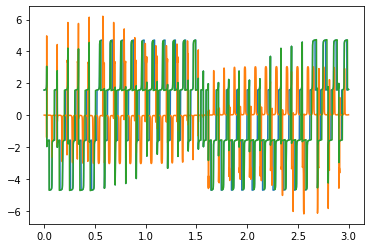

In [65]:
plt.plot(t, rel_phase_ab,t, rel_phase_ac,t, rel_phase_ad)

In [69]:
cmath.polar(a_array[1000])

In [70]:
phase_a

array([0.78539999, 0.78541281, 0.78544796, ..., 2.60176112, 2.60451794,
       2.60808686])

In [72]:
cmath.phase(complex(-1.0,0.0))

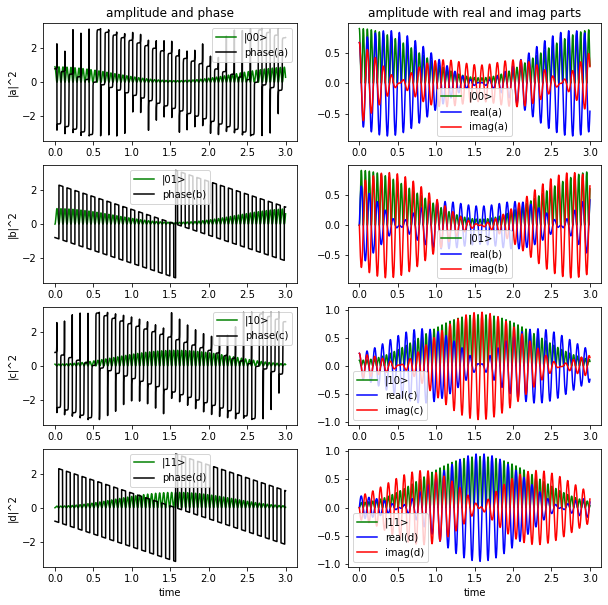

In [56]:
#phase runs from -pi to +pi

fig, axs = plt.subplots(4,2, figsize=(10,10))
axs[0,0].plot(t, a_array, 'g', label = '|00>')
axs[0,0].plot(t, phase_a, 'k', label ='phase(a)')
axs[0,0].set_ylabel(f'|a|^2')
axs[0,0].title.set_text('amplitude and phase')
#axs.set_ylabel(f'|a|^2')
axs[0,0].legend()
axs[0,1].plot(t, a_array, 'g', label = '|00>')
axs[0,1].plot(t, a_complex_real, 'b', label='real(a)')
axs[0,1].plot(t, a_complex_imag, 'r',label='imag(a)')
axs[0,1].title.set_text('amplitude with real and imag parts')
axs[0,1].legend()
#axs[0,0].set_title('prob distribution of state |00>')
axs[1,0].plot(t, b_array, 'g', label = '|01>')
axs[1,0].plot(t, phase_b, 'k', label ='phase(b)')
axs[1,0].set_ylabel(f'|b|^2')
axs[1,0].legend()
axs[1,1].plot(t, b_array, 'g', label = '|01>')
axs[1,1].plot(t, b_complex_real, 'b', label='real(b)')
axs[1,1].plot(t, b_complex_imag, 'r',label='imag(b)')
axs[1,1].legend()
axs[2,0].plot(t, c_array, 'g', label = '|10>')
axs[2,0].plot(t, phase_c, 'k', label ='phase(c)')
axs[2,0].set_ylabel(f'|c|^2')
axs[2,0].legend()
axs[2,1].plot(t, c_array, 'g', label = '|10>')
axs[2,1].plot(t, c_complex_real, 'b', label='real(c)')
axs[2,1].plot(t, c_complex_imag, 'r',label='imag(c)')
axs[2,1].legend()
axs[3,0].plot(t, d_array, 'g', label = '|11>')
axs[3,0].plot(t, phase_d, 'k', label ='phase(d)')
axs[3,0].set_ylabel(f'|d|^2')
axs[3,0].set_xlabel('time')
axs[3,0].legend()
axs[3,1].plot(t, d_array, 'g', label = '|11>')
axs[3,1].plot(t, d_complex_real, 'b', label='real(d)')
axs[3,1].plot(t, d_complex_imag, 'r',label='imag(d)')
axs[3,1].set_xlabel('time')
axs[3,1].legend()

In [252]:
Hcopy = H
E0 = 1 #variance of uniform distrib of energies E0
P = 20 / E0
J = 2 / E0
E = 20 * E0
# for i in range(n):
#     E = float(-E0/2 +(np.random.rand(1)*E0)) #onsite V for reservoir qubits
#     E_array[i] =  E #check decimals => possible errors?
    # fix value of E
Hamil = np.array(Hcopy.subs({"E_{11}":E,"P_{1}":P,
        "J_{11}":J})).astype('complex128') * 1/E0
hbar = 1
dt = 0.001 * E0/hbar
nsteps = 3000 # think like total time your simulation run for
T = nsteps  * dt #total time
t = np.arange(0, T+dt, dt) #creates array from 0 to T +dt in steps of dt

U = expm(-1j* Hamil * dt)

n = 2000
phi_initial={}
for i in range(n):
    x1 = np.random.rand(1)*np.power(-1,np.random.randint(1,3))
    y1 = np.random.rand(1)*np.power(-1,np.random.randint(1,3))
    z1 = complex(x1,y1)
    k = 1
    test0 = 0*j
    while k > 0:
        x2 = np.random.rand(1)*np.power(-1,np.random.randint(1,3))
        y2 = np.random.rand(1)*np.power(-1,np.random.randint(1,3))
        z2 = complex(x2,y2)
        if z2 == test0:
            if z2==z1:
                continue
        else: 
            break

    phi_initial[i] = z1*phi_initial_g + z2*phi_initial_e

#the |phi_initial> (x)  |vac>_QN state = |psi_initial>    
psi_initial = {}
for i in range(n):
    psi_initial[i] = 1/np.sqrt(np.abs(z1)**2+np.abs(z2)**2) * (
                MTP(phi_initial[i],vac) )
a_array = np.zeros(n*len(t),dtype=np.complex128)
b_array = np.zeros(n*len(t),dtype=np.complex128)
c_array = np.zeros(n*len(t),dtype=np.complex128)
d_array = np.zeros(n*len(t),dtype=np.complex128)
a_complex_real = np.zeros(n*len(t))
a_complex_imag = np.zeros(n*len(t),dtype=np.complex128)
b_complex_real = np.zeros(n*len(t))
b_complex_imag = np.zeros(n*len(t),dtype=np.complex128)
c_complex_real = np.zeros(n*len(t))
c_complex_imag = np.zeros(n*len(t),dtype=np.complex128)
d_complex_real = np.zeros(n*len(t))
d_complex_imag = np.zeros(n*len(t),dtype=np.complex128)
a_array_avg = np.zeros(n)
k=0
for length in range(len(psi_initial)):
    for i in range(len(t)):
        a_array[k] = np.abs(psi_initial[length][0][0])**2 #accessing 0th posn of vector 0
        b_array[k] = np.abs(psi_initial[length][1][0])**2
        c_array[k] = np.abs(psi_initial[length][2][0])**2
        d_array[k] = np.abs(psi_initial[length][3][0])**2 #accessing 3th posn of vector 0
        a_complex_real[k], a_complex_imag[k] =  psi_initial[length][0][0].real, psi_initial[length][0][0].imag
        b_complex_real[k], b_complex_imag[k] =  psi_initial[length][1][0].real, psi_initial[length][1][0].imag
        c_complex_real[k], c_complex_imag[k] =  psi_initial[length][2][0].real, psi_initial[length][2][0].imag
        d_complex_real[k], d_complex_imag[k] =  psi_initial[length][3][0].real, psi_initial[length][3][0].imag
        
        psi_initial[length] = U @ psi_initial[length] # U[0] with E[0] value
        k+=1

        

In [ ]:
Hcopy = H
E0 = 1 #variance of uniform distrib of energies E0
P = 20 / E0
J = 2 / E0
E = 20 * E0
# for i in range(n):
#     E = float(-E0/2 +(np.random.rand(1)*E0)) #onsite V for reservoir qubits
#     E_array[i] =  E #check decimals => possible errors?
    # fix value of E
Hamil = np.array(Hcopy.subs({"E_{11}":E,"P_{1}":P,
        "J_{11}":J})).astype('complex128') * 1/E0
hbar = 1
dt = 0.001 * E0/hbar
nsteps = 3000 # think like total time your simulation run for
T = nsteps  * dt #total time
t = np.arange(0, T+dt, dt) #creates array from 0 to T +dt in steps of dt

U = expm(-1j* Hamil * dt)

n = 2000
phi_initial={}
for i in range(n):
    x1 = np.random.rand(1)*np.power(-1,np.random.randint(1,3))
    y1 = np.random.rand(1)*np.power(-1,np.random.randint(1,3))
    z1 = complex(x1,y1)
    k = 1
    test0 = 0*j
    while k > 0:
        x2 = np.random.rand(1)*np.power(-1,np.random.randint(1,3))
        y2 = np.random.rand(1)*np.power(-1,np.random.randint(1,3))
        z2 = complex(x2,y2)
        if z2 == test0:
            if z2==z1:
                continue
        else: 
            break

    phi_initial[i] = z1*phi_initial_g + z2*phi_initial_e

#the |phi_initial> (x)  |vac>_QN state = |psi_initial>    
psi_initial = {}
for i in range(n):
    psi_initial[i] = 1/np.sqrt(np.abs(z1)**2+np.abs(z2)**2) * (
                MTP(phi_initial[i],vac) )

#################################################

# defining complex coefficients and real/imag variables for evolved state
a_array = np.zeros(n,dtype=np.complex128)
b_array = np.zeros(n,dtype=np.complex128)
c_array = np.zeros(n,dtype=np.complex128)
d_array = np.zeros(n,dtype=np.complex128)
a_complex_real = np.zeros(n)
a_complex_imag = np.zeros(n,dtype=np.complex128)
b_complex_real = np.zeros(n)
b_complex_imag = np.zeros(n,dtype=np.complex128)
c_complex_real = np.zeros(n)
c_complex_imag = np.zeros(n,dtype=np.complex128)
d_complex_real = np.zeros(n)
d_complex_imag = np.zeros(n,dtype=np.complex128)
k=0
for length in range(len(psi_initial)):
    for i in range(len(t)):
        a_array[k] = np.abs(psi_initial[length][0][0])**2 #accessing 0th posn of vector 0
        b_array[k] = np.abs(psi_initial[length][1][0])**2
        c_array[k] = np.abs(psi_initial[length][2][0])**2
        d_array[k] = np.abs(psi_initial[length][3][0])**2 #accessing 3th posn of vector 0
        psi_initial[length] = U @ psi_initial[length] # U[0] with E[0] value
        a_complex_real[k], a_complex_imag[k] =  psi_initial[length][0][0].real, psi_initial[length][0][0].imag
        b_complex_real[k], b_complex_imag[k] =  psi_initial[length][1][0].real, psi_initial[length][1][0].imag
        c_complex_real[k], c_complex_imag[k] =  psi_initial[length][2][0].real, psi_initial[length][2][0].imag
        d_complex_real[k], d_complex_imag[k] =  psi_initial[length][3][0].real, psi_initial[length][3][0].imag
        k+=1

        
#so my a_array and such going to contain values for both initial states
#0 and 1

#a_array[0:nsteps+1], a_array[nsteps+1:] = (first vector, second vector) 


###########################################################################
#div, len(a_array), 
#a_array[0:nsteps+1], a_array[nsteps+1:] = (first vector, second vector) 
###########################################################################

# plt.plot(t,a_array[0:nsteps+1],'b',label='|00>')
# plt.plot(t,b_array[0:nsteps+1],'g',label='|01>')
# plt.plot(t,c_array[0:nsteps+1],'r',label='|10>')
# plt.plot(t,d_array[0:nsteps+1],'k',label='|11>')
# plt.legend()
# plt.show()


fig, axs = plt.subplots(2,2)
axs[0,0].plot(t,a_array[0:nsteps+1],'b',label='|00>')
axs[0,0].legend()
#axs[0,0].set_title('prob distribution of state |00>')
axs[0,1].plot(t, b_array[0:nsteps+1],'g',label='|01>')
axs[0,1].legend()
axs[1,0].plot(t, c_array[0:nsteps+1],'r',label='|10>')
axs[1,0].legend()
axs[1,1].plot(t, d_array[0:nsteps+1],'k',label='|11>')
axs[1,1].legend()

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='complex # squared')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
print('\nP = ', P, '\tJ = ', J, '\tE = ', E_array[0],'\nInitial State = ',
     psi_initial[0])
# ##########################################################################################

# E = -0.0829806823365895
# E =  -0.23904176709730762 
# E =  0.4528425029534273 
# E =  -0.40402154911946553 
# E =  0.45078074750701513 